In [117]:
import networkx as nx
import copy
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
from osmnx.save_load import graph_to_gdfs
import os
from itertools import islice
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sb


%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

## Configure

In [3]:
run_label = "san_francisco"

In [23]:
config = pd.read_csv("config.csv", quotechar='"', skipinitialspace=True)

config.set_index("label", inplace=True)

In [24]:
assert run_label in config.index
config

,address,buffer
label,,
san_francisco,"San Francisco, California, USA",10000
new_york,"New York City, New York, USA",10


## Load Data

In [57]:
LG = nx.read_graphml('experiments/line_graphs/' + run_label + ".graphml", node_type=int)

In [58]:
len(LG)

84613

In [62]:
for n in islice(LG.nodes(data=True), 5):
    print(n)

(52058, {'oneway': 'False', 'length': '63.638', 'speed_mph_mean': '15.025124999999997', 'speed_mph_p50': '14.870125000000002', 'speed_mph_p85': '19.146375'})
(79710, {'oneway': 'True', 'length': '91.796', 'speed_mph_mean': '26.985', 'speed_mph_p50': '26.953000000000003', 'speed_mph_p85': '30.587666666666667'})
(21972, {'oneway': 'True', 'length': '19.024', 'speed_mph_mean': '31.8625', 'speed_mph_p50': '32.348', 'speed_mph_p85': '37.51049999999999'})
(6054, {'oneway': 'False', 'length': '87.7', 'speed_mph_mean': '16.874785714285714', 'speed_mph_p50': '16.703285714285716', 'speed_mph_p85': '19.33385714285714'})
(30709, {'oneway': 'False', 'length': '73.13', 'speed_mph_mean': '11.46', 'speed_mph_p50': '11.773', 'speed_mph_p85': '14.0'})


## Build Basic Features

In [172]:
# feature 1, road length
length = [LG.nodes[i]["length"] for i in range(len(LG))]

# feature 2, one way?
one_way = [LG.nodes[i]["oneway"] for i in range(len(LG))]

# feature 3, out-degree
out_degree = [LG.out_degree(i) for i in range(len(LG))]

# feature 4, in-degree
in_degree = [LG.in_degree(i) for i in range(len(LG))]

# target 1, mean speed
speed_mean = [LG.nodes[i].get("speed_mph_mean", np.NaN) for i in range(len(LG))]

# target 2, median speed
speed_p50 = [LG.nodes[i].get("speed_mph_p50", np.NaN) for i in range(len(LG))]

# target 3, free flow speed
speed_p85 = [LG.nodes[i].get("speed_mph_p85", np.NaN) for i in range(len(LG))]

In [173]:
features = pd.DataFrame({"length": length,
                         "one_way": one_way,
                         "out_degree": out_degree,
                         "in_degree": in_degree})

features["length"] = features['length'].astype('float')
features["one_way"] = features['length'].astype('bool')

targets = pd.DataFrame({"speed_mean": speed_mean,
                        "speed_p50": speed_p50,
                        "speed_p85": speed_p85})

targets["speed_mean"] = targets["speed_mean"].astype('float')
targets["speed_p50"] = targets["speed_p50"].astype('float')
targets["speed_p85"] = targets["speed_p85"].astype('float')

## Recursive Features

In [202]:
def extend_recursive_features(LG, features, aggs=['mean']):
    if type(features) == pd.core.frame.DataFrame:
        features = features.to_numpy()
    
    rows, cols = features.shape
    col_multiplier = 1 + 2 * len(aggs)
    new_features = np.zeros((rows, col_multiplier * cols))
    
    new_features[:, :cols] = features
    
    for i in range(len(LG)):
        pred = list(LG.predecessors(i))
        succ = list(LG.successors(i))
        
        curr_col = cols
        
        if 'mean' in aggs:
            if len(pred) > 0:
                new_features[i, curr_col:curr_col+cols] = features[pred, :].mean(axis=0)
                curr_col += cols
            if len(succ) > 0:
                new_features[i, curr_col:curr_col+cols] = features[succ, :].mean(axis=0)
                curr_col += cols
            
        if 'sum' in aggs:
            if len(pred) > 0:
                new_features[i, curr_col:curr_col+cols] = features[pred, :].sum(axis=0)
                curr_col += cols
            if len(succ) > 0:
                new_features[i, curr_col:curr_col+cols] = features[succ, :].sum(axis=0)
                curr_col += cols
                
        if 'max' in aggs:
            if len(pred) > 0:
                new_features[i, curr_col:curr_col+cols] = features[pred, :].sum(axis=0)
                curr_col += cols
            if len(succ) > 0:
                new_features[i, curr_col:curr_col+cols] = features[succ, :].sum(axis=0)
                curr_col += cols
            
    return new_features

def build_recursive_features(LG, features, n, aggs=['mean']):
    for i in range(n):
        features = extend_recursive_features(LG, features)
    return features

In [213]:
X = features[["length", "in_degree", "out_degree"]]
X_1 = build_recursive_features(LG, X, 1, aggs=['mean', 'sum', 'max'])
X_2 = build_recursive_features(LG, X, 2, aggs=['mean', 'sum', 'max'])

X = sm.add_constant(X)
X_1 = sm.add_constant(X_1)
X_2 = sm.add_constant(X_2)

Y = targets["speed_p85"]

## Linear Model

In [214]:
model = sm.OLS(Y, X, missing='drop')
model_1 = sm.OLS(Y, X_1, missing='drop')
model_2 = sm.OLS(Y, X_2, missing='drop')

fit = model.fit()
fit_1 = model_1.fit()
fit_2 = model_2.fit()

print(fit.summary())
print(fit_1.summary())
#print(fit_2.summary())

                            OLS Regression Results                            
Dep. Variable:              speed_p85   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     6467.
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:38:43   Log-Likelihood:            -1.6429e+05
No. Observations:               49440   AIC:                         3.286e+05
Df Residuals:                   49436   BIC:                         3.286e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4519      0.133    259.900      0.0

In [215]:
model = sm.OLS(Y, X, missing='drop')
model_1 = sm.OLS(Y, X_1, missing='drop')
model_2 = sm.OLS(Y, X_2, missing='drop')

fit = model.fit()
fit_1 = model_1.fit()
fit_2 = model_2.fit()

print(fit.summary())
print(fit_1.summary())

                            OLS Regression Results                            
Dep. Variable:              speed_p85   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     6467.
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:39:08   Log-Likelihood:            -1.6429e+05
No. Observations:               49440   AIC:                         3.286e+05
Df Residuals:                   49436   BIC:                         3.286e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4519      0.133    259.900      0.0

In [217]:
fit_reg = model.fit_regularized()
fit_reg_1 = model_1.fit_regularized()
fit_reg_2 = model_2.fit_regularized()

print(fit_reg.summary())
print(fit_reg_1.summary())
#print(fit_2.summary())

NotImplementedError: 

In [ ]:
type(fit_reg)

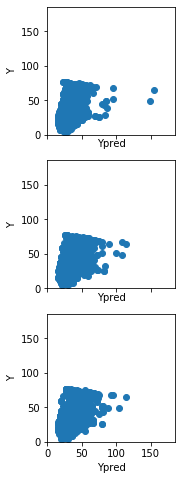

In [211]:
Ypred = fit.predict(X)
Ypred_1 = fit_1.predict(X_1)
Ypred_2 = fit_2.predict(X_2)

f, axes = plt.subplots(3, figsize=(12,8), sharex=True)
max_val = max(Ypred.max(), Ypred_1.max(), Ypred_2.max())
for i, Ypred in enumerate([Ypred, Ypred_1, Ypred_2]):
    axes[i].set_aspect('equal')
    axes[i].set_xlim(0, max_val + 5)
    axes[i].set_ylim(0, max_val + 5)
    axes[i].set_xlabel("Ypred")
    axes[i].set_ylabel("Y")
    axes[i].scatter(Ypred, Y)

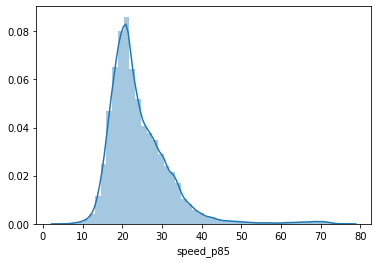

In [176]:
sb.distplot(Y[~Y.isna()])

In [189]:
rec_features = build_recursive_features(LG, X, 1)

In [190]:
rec_features.shape

(84613, 20)

In [ ]:
X = build_recursive_features(LG, X, 1)
X = sm.add_constant(X)
Y = targets["speed_p85"]

model = sm.OLS(Y, X, missing='drop')
fit = model.fit()

print(fit.summary())